In [11]:
# # setup for the colab

# import os
# os.environ['KAGGLE_USERNAME'] = "kirillfedyanin"
# os.environ['KAGGLE_KEY'] = ""
# !pip install imageio
# !pip install keras 
# !pip install kaggle

# !kaggle competitions download -c tgs-salt-identification-challenge
# !mkdir -p test
# !mkdir -p train
# !unzip test.zip -d test
# !unzip train.zip -d train

In [12]:
import os
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imageio
from skimage.transform import resize

In [91]:
HEIGHT, WIDTH = 101, 101
MODEL_FILE = 'unet_basic.h5'
SUBMISSION_FILE = 'submission.csv'

In [14]:
root_path = './'

def get_image(file_id, mode='train'):
    image_path = os.path.join(root_path, mode, "images", file_id + '.png')
    image = np.array(imageio.imread(image_path), dtype=np.uint8)
    return image

def get_mask(file_id):
    mask_path = os.path.join(root_path, "train", "masks", file_id + '.png')
    mask = np.array(imageio.imread(mask_path), dtype=np.uint8)
    return mask

In [15]:
train_values = pd.read_csv('train.csv')
file_list = list(train_values['id'])

# Reasearch
Do some data digging

In [16]:
def rle_to_mask(rle_string):
    if isinstance(rle_string, float) and np.isnan(rle_string):
        return np.zeros((HEIGHT, WIDTH)) 
    rle_numbers = [int(num) for num in rle_string.split()] 
    rle_pairs = np.array(rle_numbers).reshape((-1, 2))
    
    mask = np.zeros(HEIGHT*WIDTH)
    for start, length in rle_pairs:
        mask[start-1: start-1+length] = 255
    
    mask = mask.reshape((HEIGHT, WIDTH)).T
        
    return mask


2088 is correct:  True
155 is correct:  True
3563 is correct:  True
1819 is correct:  True
1627 is correct:  True
3162 is correct:  True
3202 is correct:  True
921 is correct:  True
1270 is correct:  True
1769 is correct:  True
3953 is correct:  True
3814 is correct:  True
2078 is correct:  True
1269 is correct:  True
1426 is correct:  True


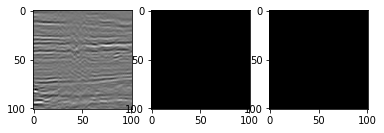

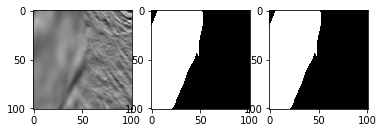

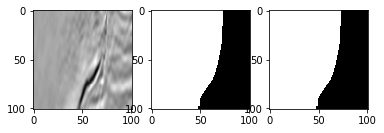

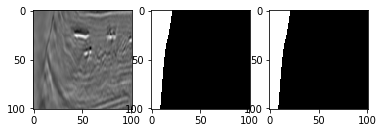

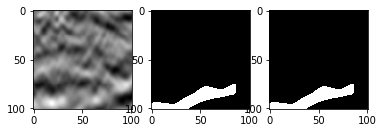

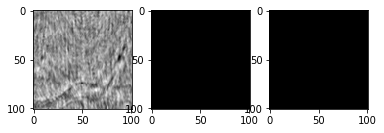

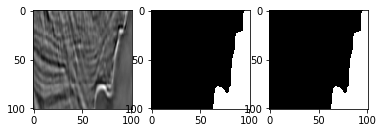

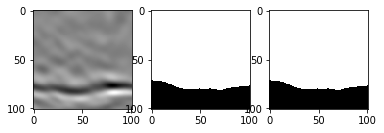

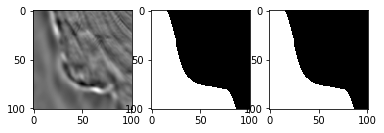

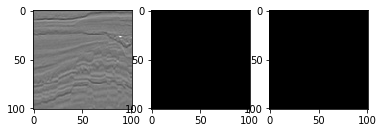

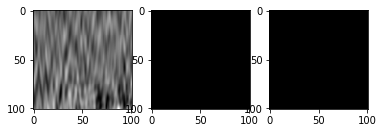

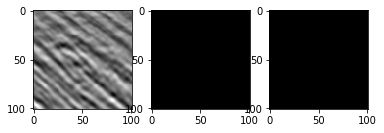

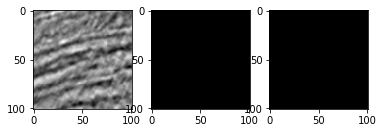

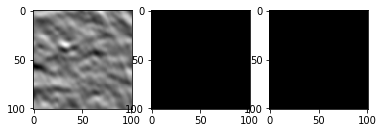

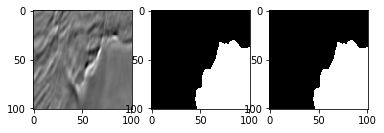

In [17]:
# check if masks correctly oriented
for _ in range(15):
    i = random.randint(0, len(file_list)-1) 
    file_id = file_list[i]
    image, mask = get_image(file_id), get_mask(file_id)
    f, axarr = plt.subplots(1, 3)
    axarr[0].imshow(image)
    axarr[1].imshow(mask, cmap='gray')
    axarr[2].imshow(rle_to_mask(train_values['rle_mask'][i]), cmap='gray')
    print(i, 'is correct: ', (mask==rle_to_mask(train_values['rle_mask'][i])).all())
    

(array([ 14.,  28.,  42.,  58.,  43.,  60.,  42.,  51.,  65.,  72.,  65.,
         74.,  70.,  85.,  88.,  95.,  95.,  89., 110.,  88., 114., 114.,
        128., 125., 125., 119., 118., 127., 110., 130., 108., 122., 102.,
        119., 113., 119., 106.,  84.,  84.,  72.,  80.,  87.,  65.,  80.,
         18.,  27.,  13.,  15.,  13.,  29.]),
 array([ 51.  ,  69.16,  87.32, 105.48, 123.64, 141.8 , 159.96, 178.12,
        196.28, 214.44, 232.6 , 250.76, 268.92, 287.08, 305.24, 323.4 ,
        341.56, 359.72, 377.88, 396.04, 414.2 , 432.36, 450.52, 468.68,
        486.84, 505.  , 523.16, 541.32, 559.48, 577.64, 595.8 , 613.96,
        632.12, 650.28, 668.44, 686.6 , 704.76, 722.92, 741.08, 759.24,
        777.4 , 795.56, 813.72, 831.88, 850.04, 868.2 , 886.36, 904.52,
        922.68, 940.84, 959.  ]),
 <a list of 50 Patch objects>)

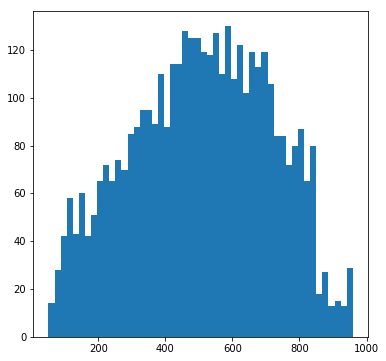

In [18]:
depths = pd.read_csv("depths.csv")

train_values['depths'] = depths['z']

plt.figure(figsize=(6, 6))
plt.hist(train_values['depths'], bins=50)


In [19]:
norm = HEIGHT * WIDTH * 255.0
def salt_concentration(mask):
    return np.sum(mask)/norm

masks = [get_mask(file_id) for file_id in train_values['id']]
train_values['salt_concentration'] = [salt_concentration(mask) for mask in masks]

In [20]:
train_val = train_values.merge(depths, how='left')

Text(0.5, 1.0, 'Depths vs salt concentration')

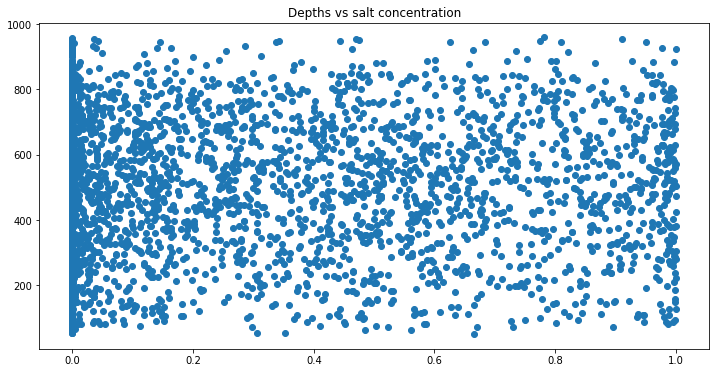

In [21]:
plt.figure(figsize=(12, 6))
plt.scatter(train_val['salt_concentration'], train_val['depths'])
plt.title("Depths vs salt concentration")

# Model training itself

**what to do**
- dropout
- model saving
- unet connections
- regularization
- augmentation
- submission


In [22]:
from keras.layers import Input, Dense, Conv2D, UpSampling2D, MaxPooling2D, concatenate, ZeroPadding2D, Cropping2D
from keras.models import Model

def salt_detector():
    common_atr = {'activation': 'relu', 'padding': 'same'}
    
    input_image = Input(shape=(101, 101, 1))
    x = ZeroPadding2D(((0, 27), (0, 27)))(input_image)
    conv1 = Conv2D(16, (3, 3), **common_atr)(x)
    conv1 = Conv2D(16, (3, 3), **common_atr)(conv1)
    max1 = MaxPooling2D((2, 2), padding='same')(conv1)
    
    conv2 = Conv2D(32, (3, 3), **common_atr)(max1)
    conv2 = Conv2D(32, (3, 3), **common_atr)(conv2)
    max2 = MaxPooling2D((2, 2), padding='same')(conv2)
    
    conv3 = Conv2D(64, (3, 3), **common_atr)(max2)
    conv3 = Conv2D(64, (3, 3), **common_atr)(conv3)
    encoded = MaxPooling2D((2, 2), padding='same')(conv3)
    
    conv10 = Conv2D(64, (3, 3), **common_atr)(encoded)
    conv10 = Conv2D(64, (3, 3), **common_atr)(conv10)
    
    up11 = UpSampling2D((2, 2))(conv10)
    merged11 = concatenate([up11, conv3], axis=3)
    conv11 = Conv2D(32, (3, 3), **common_atr)(merged11)
    conv11 = Conv2D(32, (3, 3), **common_atr)(conv11)
    
    up12 = UpSampling2D((2, 2))(conv11)
    merged12 = concatenate([up12, conv2], axis=3)
    conv12 = Conv2D(16, (3, 3), **common_atr)(merged12)
    conv12 = Conv2D(16, (3, 3), **common_atr)(conv12)
    
    up13 = UpSampling2D((2, 2))(conv12)
    merged13 = concatenate([up13, conv1], axis=3)
    conv13 = conv12 = Conv2D(16, (3, 3), **common_atr)(merged13)
    conv13 = conv12 = Conv2D(16, (3, 3), **common_atr)(conv13)
    
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(conv13)
    decoded_cropped = Cropping2D(((0, 27), (0, 27)))(decoded)
    
    autoencoder = Model(input_image, decoded_cropped)
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    
    return autoencoder

detector = salt_detector()
detector.summary()


Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 101, 101, 1)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 128, 128, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 160         zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 16) 2320        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [23]:
def prepare(images):
    images = np.stack(images)
    images = images[:, :, :, :1].astype('float32') / 255.
    return images

In [24]:
labels = prepare([get_mask(file_id)[:,:,np.newaxis] for file_id in file_list])
images = prepare([get_image(file_id) for file_id in file_list])

In [25]:
val_size = 512
images_train, images_val = images[:-val_size], images[-val_size:]
labels_train, labels_val = labels[:-val_size], labels[-val_size:]

In [26]:
detector.fit(images_train, labels_train, epochs=100, batch_size=64, shuffle=True, validation_data=(images_val, labels_val) )

Train on 3488 samples, validate on 512 samples
Epoch 1/100
3488/3488 [==============================] - 104s 30ms/step - loss: 0.5802 - val_loss: 0.5673
Epoch 2/100
3488/3488 [==============================] - 103s 30ms/step - loss: 0.5609 - val_loss: 0.5640
Epoch 3/100
3488/3488 [==============================] - 104s 30ms/step - loss: 0.5580 - val_loss: 0.5499
Epoch 4/100
3488/3488 [==============================] - 104s 30ms/step - loss: 0.5495 - val_loss: 0.5425
Epoch 5/100
3488/3488 [==============================] - 104s 30ms/step - loss: 0.5401 - val_loss: 0.5685
Epoch 6/100
3488/3488 [==============================] - 105s 30ms/step - loss: 0.5112 - val_loss: 0.4581
Epoch 7/100
3488/3488 [==============================] - 104s 30ms/step - loss: 0.4745 - val_loss: 0.4372
Epoch 8/100
3488/3488 [==============================] - 106s 30ms/step - loss: 0.4230 - val_loss: 0.4496
Epoch 9/100
3488/3488 [==============================] - 105s 30ms/step - loss: 0.3883 - val_loss: 0.4201

In [72]:
detector.save(os.path.join(root_path, 'models', MODEL_FILE))

In [28]:
def threshold_image(image, threshold=0.5):
    image[image>threshold] = 1
    image[image<=threshold] = 0
    return image

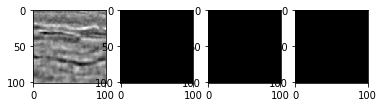

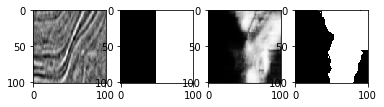

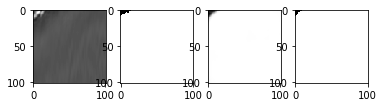

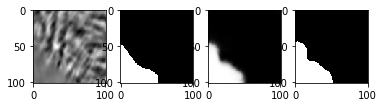

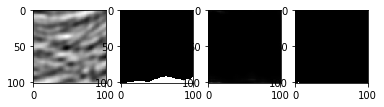

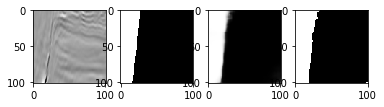

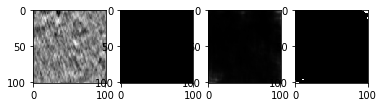

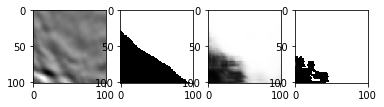

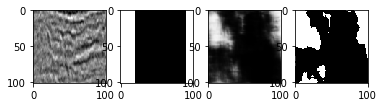

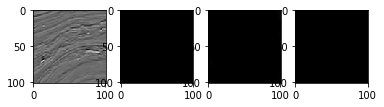

In [29]:
for i in range(10):
    image = images[i]
    label = labels[i]
    prediction = detector.predict(images[i:i+1])[0]
    _, axarr = plt.subplots(1, 4)
    axarr[0].imshow(image[:, :, 0], cmap='gray')
    axarr[1].imshow(label[:, :, 0], cmap='gray', vmin=0, vmax=1)
    axarr[2].imshow(prediction[:, :, 0], cmap='gray', vmin=0, vmax=1)
    axarr[3].imshow(threshold_image(prediction[:, :, 0], 0.2), cmap='gray', vmin=0, vmax=1)


In [68]:
def encode_rle(mask):
    mask = mask.reshape(HEIGHT, WIDTH).T.reshape(-1)
    
    rle_array = []
    white_start = 0 
    for i, value in enumerate(mask):
        if value == 0 and white_start:
            rle_array.extend([white_start, i+1-white_start])
            white_start = 0
        elif value == 1 and not white_start:
            white_start = i + 1
    if white_start:
        rle_array.extend([white_start, len(mask)+1-white_start])
                
    rle_encoded = ' '.join(map(str, rle_array))
    return rle_encoded

In [ ]:
# validate rle encoder
for some_index in range(99):
    file_id_ = file_list[some_index]
    msk = get_mask(file_id_) / 255.0
    correct_mask = train_values['rle_mask'][some_index]
    encoded = encode_rle(msk)
    print(encoded == correct_mask or (not encoded and np.isnan(correct_mask)), end= ' ')

In [47]:
# how to prepare submission
test_path = os.path.join(root_path, 'test', 'images')
test_file_list = [os.path.splitext(file_name)[0] for file_name in os.listdir(test_path) if os.path.isfile(os.path.join(test_path, file_name))]




In [48]:
test_images = prepare([get_image(file_id, 'test') for file_id in test_file_list])

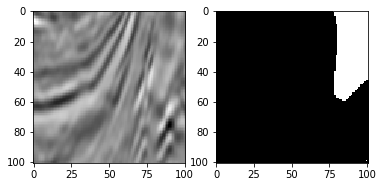

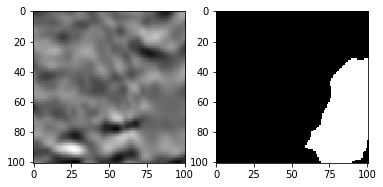

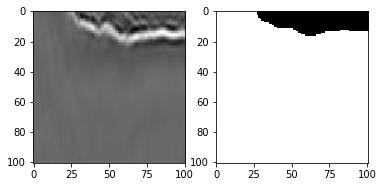

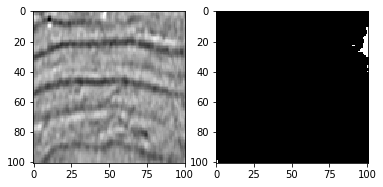

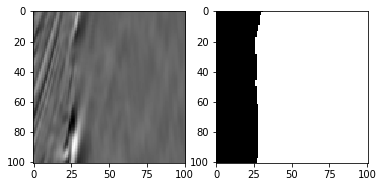

In [65]:
predicted = detector.predict(test_images[:5])
for i in range(5):
    f, axarr = plt.subplots(1, 2)
    img = get_image(test_file_list[i], 'test')
    axarr[0].imshow(img)
    axarr[1].imshow(threshold_image(predicted[i, :, :, 0]), cmap='gray')


In [66]:
predicted = detector.predict(test_images)


In [75]:
thresholded = [threshold_image(mask) for mask in predicted]

In [77]:
encoded_rle = [encode_rle(mask) for mask in thresholded]

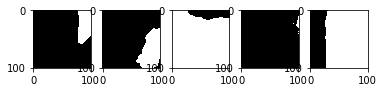

In [83]:
# encoded_rle
f, axarr = plt.subplots(1, 5)
for i in range(5):
    axarr[i].imshow(thresholded[i][:, :, 0], cmap='gray')

In [87]:
submission_df = pd.DataFrame({'id': test_file_list, 'rle_mask': encoded_rle})

In [92]:
submission_df.to_csv(SUBMISSION_FILE, index=False)

In [93]:
!kaggle competitions submit -c tgs-salt-identification-challenge -f submission.csv -m "Basic unet"

100%|██████████████████████████████████████| 5.37M/5.37M [00:05<00:00, 1.05MB/s]
Successfully submitted to TGS Salt Identification Challenge